In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm



# Load ESC-50 dataset metadata
ESC50_CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/meta/esc50.csv"
AUDIO_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/audio"
df = pd.read_csv(ESC50_CSV_PATH)


# Function to extract stacked features (MFCC, GTCC, Chroma Fourier Transform, Mel Spectrogram)
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    y, sr = librosa.load(file_path, sr=sr, duration=3.0)

    if np.max(np.abs(y)) < 1e-5:
        y += np.random.normal(0, 1e-5, size=y.shape)  # Add small noise floor to avoid silent frames

    # Compute features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    gtcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Placeholder for GTCC computation
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Resize features to ensure uniform shape
    def resize_feature(feature, target_size):
        return np.pad(feature, ((0, max(0, target_size[0] - feature.shape[0])),
                                 (0, max(0, target_size[1] - feature.shape[1]))), mode='constant')

    mfcc = resize_feature(mfcc, target_size)
    gtcc = resize_feature(gtcc, target_size)
    chroma = resize_feature(chroma, target_size)
    mel_spec = resize_feature(mel_spec, target_size)

    stacked_features = np.stack([mfcc, gtcc, chroma, mel_spec], axis=-1)
    return stacked_features



# Prepare dataset
X, y = [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(AUDIO_PATH, row['filename'])
    label = row['category']
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = pd.Series(y).factorize()[0]

# Normalize features
scaler = StandardScaler()
X = np.array([scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape) for x in X])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)



# Define CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



# Train the CNN model
input_shape = (128, 128, 4)
model = create_cnn_model(input_shape, num_classes)

# Train model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


from sklearn.metrics import classification_report, accuracy_score

# Extract final training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert softmax outputs to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to class labels

# Compute classification metrics
report = classification_report(y_true, y_pred, digits=4, output_dict=True)

# Extract precision, recall, and F1-score
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")


  2%|▏         | 38/2000 [00:46<12:40,  2.58it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 2000/2000 [12:36<00:00,  2.64it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 872ms/step - accuracy: 0.0196 - loss: 3.9121 - val_accuracy: 0.0450 - val_loss: 3.7583
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 902ms/step - accuracy: 0.0608 - loss: 3.5604 - val_accuracy: 0.1075 - val_loss: 3.1440
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 879ms/step - accuracy: 0.1303 - loss: 3.0410 - val_accuracy: 0.2250 - val_loss: 2.6673
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 868ms/step - accuracy: 0.2311 - loss: 2.6580 - val_accuracy: 0.2650 - val_loss: 2.5699
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 887ms/step - accuracy: 0.3246 - loss: 2.3581 - val_accuracy: 0.3050 - val_loss: 2.2510
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 903ms/step - accuracy: 0.3744 - loss: 2.1249 - val_accuracy: 0.2950 - val_loss: 2.2823
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 850ms/step - accuracy: 0.4210 - loss: 1.9524 - val_accuracy: 0.4100 - val_loss: 1.9449
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 908ms/step - accuracy: 0.4573 - loss: 1.8046 - 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  2%|▏         | 38/2000 [00:43<14:59,  2.18it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 2000/2000 [16:21<00:00,  2.04it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 913ms/step - accuracy: 0.0206 - loss: 3.9166 - val_accuracy: 0.0300 - val_loss: 3.8745
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 895ms/step - accuracy: 0.0554 - loss: 3.6358 - val_accuracy: 0.1050 - val_loss: 3.2365
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 906ms/step - accuracy: 0.1049 - loss: 3.1917 - val_accuracy: 0.1825 - val_loss: 2.8821
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 944ms/step - accuracy: 0.2026 - loss: 2.7833 - val_accuracy: 0.2650 - val_loss: 2.5112
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 945ms/step - accuracy: 0.2772 - loss: 2.4749 - val_accuracy: 0.3075 - val_loss: 2.3826
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 904ms/step - accuracy: 0.3439 - loss: 2.2303 - val_accuracy: 0.3500 - val_loss: 2.1075
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 905ms/step - accuracy: 0.4013 - loss: 2.0179 - val_accuracy: 0.4150 - val_loss: 1.9881
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 909ms/step - accuracy: 0.4697 - loss: 1.7727 - 

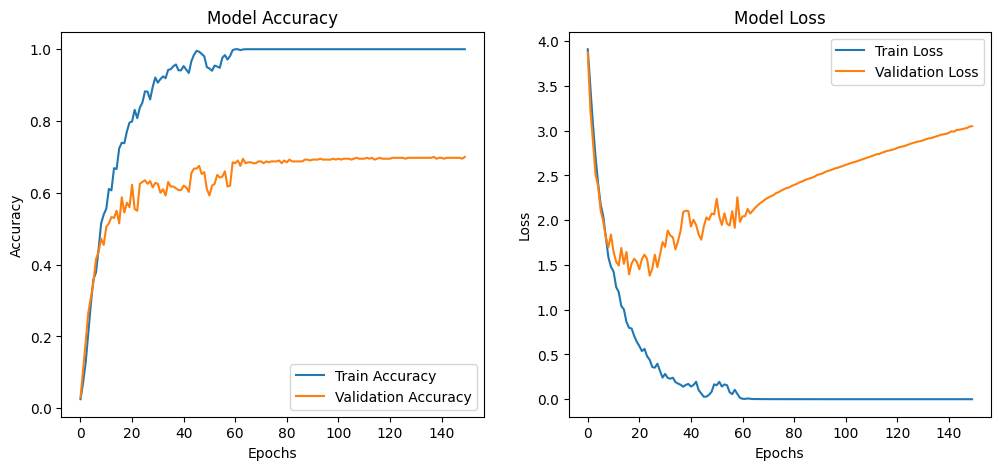

Model saved at /content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/model/audio_classification_model.h5


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load ESC-50 dataset metadata
ESC50_CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/meta/esc50.csv"
AUDIO_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/audio"
df = pd.read_csv(ESC50_CSV_PATH)

# Function to extract stacked features
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    y, sr = librosa.load(file_path, sr=sr, duration=3.0)
    if np.max(np.abs(y)) < 1e-5:
        y += np.random.normal(0, 1e-5, size=y.shape)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    gtcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Placeholder for GTCC computation
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    def resize_feature(feature, target_size):
        return np.pad(feature, ((0, max(0, target_size[0] - feature.shape[0])),
                                 (0, max(0, target_size[1] - feature.shape[1]))), mode='constant')

    mfcc = resize_feature(mfcc, target_size)
    gtcc = resize_feature(gtcc, target_size)
    chroma = resize_feature(chroma, target_size)
    mel_spec = resize_feature(mel_spec, target_size)

    stacked_features = np.stack([mfcc, gtcc, chroma, mel_spec], axis=-1)
    return stacked_features

# Prepare dataset
X, y = [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(AUDIO_PATH, row['filename'])
    label = row['category']
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = pd.Series(y).factorize()[0]

# Normalize features
scaler = StandardScaler()
X = np.array([scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape) for x in X])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train the CNN model
input_shape = (128, 128, 4)
model = create_cnn_model(input_shape, num_classes)

# Train model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# Save the trained model
MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/model/audio_classification_model.h5"
model.save(MODEL_SAVE_PATH)
print(f"Model saved at {MODEL_SAVE_PATH}")


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load Pre-trained Model
MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/model/audio_classification_model.h5"
model = load_model(MODEL_SAVE_PATH)
print("Pre-trained model loaded successfully.")

# Load UrbanSound8K Dataset Metadata
URBAN_CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
AUDIO_FOLDER = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"
df_urban = pd.read_csv(URBAN_CSV_PATH)

# Function to extract features
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        if np.max(np.abs(y)) < 1e-5:
            y += np.random.normal(0, 1e-5, size=y.shape)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        gtcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Placeholder for GTCC computation
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        def resize_feature(feature, target_size):
            return np.pad(feature, ((0, max(0, target_size[0] - feature.shape[0])),
                                     (0, max(0, target_size[1] - feature.shape[1]))), mode='constant')

        mfcc = resize_feature(mfcc, target_size)
        gtcc = resize_feature(gtcc, target_size)
        chroma = resize_feature(chroma, target_size)
        mel_spec = resize_feature(mel_spec, target_size)

        stacked_features = np.stack([mfcc, gtcc, chroma, mel_spec], axis=-1)
        return stacked_features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Prepare UrbanSound8K dataset
X_urban, y_urban = [], []
for _, row in tqdm(df_urban.iterrows(), total=len(df_urban)):
    file_path = os.path.join(AUDIO_FOLDER, f"fold{row['fold']}/{row['slice_file_name']}")
    label = row['classID']
    features = extract_features(file_path)
    if features is not None and features.shape == (128, 128, 4):  # Ensure correct shape
        X_urban.append(features)
        y_urban.append(label)

X_urban = np.array(X_urban, dtype=np.float32)  # Ensure homogeneous array
y_urban = np.array(y_urban, dtype=np.int64)

# Normalize features
scaler = StandardScaler()
X_urban = np.array([scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape) for x in X_urban])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_urban, y_urban, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_urban))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Modify model if class count differs
if model.output_shape[-1] != num_classes:
    model.pop()
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune Model on UrbanSound8K
epochs = 50  # Fewer epochs for fine-tuning
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"UrbanSound8K Test Accuracy: {accuracy:.4f}")

# Save the retrained model
URBAN_MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/model/audio_classification_model_urban.h5"
model.save(URBAN_MODEL_SAVE_PATH)
print(f"Re-trained model saved at {URBAN_MODEL_SAVE_PATH}")


Pre-trained model loaded successfully.


  1%|          | 66/8732 [00:07<13:01, 11.09it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 41%|████      | 3555/8732 [05:26<12:42,  6.79it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8324/8732 [12:12<00:24, 16.78it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8327/8732 [12:12<00:20, 19.37it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [12:46<00:00, 11.40it/s]


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 916ms/step - accuracy: 0.4492 - loss: 1.9416 - val_accuracy: 0.7778 - val_loss: 0.8712
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 897ms/step - accuracy: 0.7648 - loss: 0.6889 - val_accuracy: 0.7857 - val_loss: 0.6774
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 920ms/step - accuracy: 0.8329 - loss: 0.4580 - val_accuracy: 0.8095 - val_loss: 0.6057
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 854ms/step - accuracy: 0.8710 - loss: 0.3933 - val_accuracy: 0.8611 - val_loss: 0.4946
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 816ms/step - accuracy: 0.8994 - loss: 0.2948 - val_accuracy: 0.8333 - val_loss: 0.6219
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 827ms/step - accuracy: 0.8958 - loss: 0.2816 - val_accuracy: 0.8690 - val_loss: 0.4652
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 834ms/step - accuracy: 0.9418 - loss: 0.2056 - val_accuracy: 0.8849 - val_loss: 0.4945
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 804ms/step - accuracy: 0.9592 - loss: 0.1561 - val_accu

UrbanSound8K Test Accuracy: 0.9246
Re-trained model saved at /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/model/audio_classification_model_urban.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 611ms/step - accuracy: 0.9021 - loss: 0.4817
UrbanSound8K Test Accuracy: 0.9246


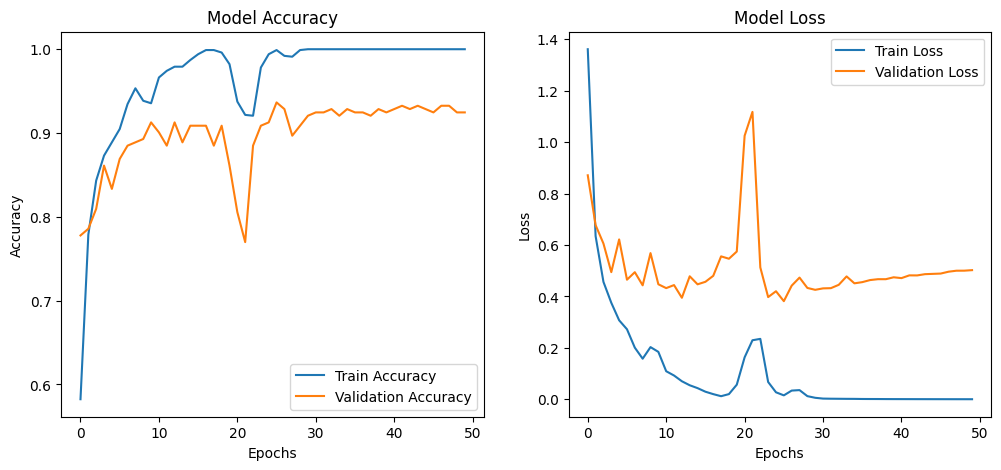

In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"UrbanSound8K Test Accuracy: {accuracy:.4f}")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"UrbanSound8K Test Accuracy: {accuracy:.4f}")

# Extract training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Compute classification metrics
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert softmax outputs to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to class labels

report = classification_report(y_true, y_pred, digits=4, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Print evaluation metrics
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 0.9021 - loss: 0.4817
UrbanSound8K Test Accuracy: 0.9246
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step
Training Accuracy: 1.0000
Validation Accuracy: 0.9246
Precision: 0.9234
Recall: 0.9246
F1-score: 0.9212


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pre-trained model loaded successfully.


  1%|          | 67/8732 [00:04<09:50, 14.66it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 41%|████      | 3555/8732 [04:57<05:27, 15.79it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8325/8732 [11:16<00:20, 19.74it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8329/8732 [11:16<00:16, 24.28it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [11:47<00:00, 12.35it/s]


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 866ms/step - accuracy: 0.4077 - loss: 2.1663 - val_accuracy: 0.6627 - val_loss: 1.0195
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 877ms/step - accuracy: 0.7288 - loss: 0.7408 - val_accuracy: 0.8016 - val_loss: 0.6805
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 933ms/step - accuracy: 0.8281 - loss: 0.5090 - val_accuracy: 0.8135 - val_loss: 0.5840
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 938ms/step - accuracy: 0.8596 - loss: 0.3889 - val_accuracy: 0.8492 - val_loss: 0.5278
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8925 - loss: 0.2968 - val_accuracy: 0.8532 - val_loss: 0.4557
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 896ms/step - accuracy: 0.9270 - loss: 0.2290 - val_accuracy: 0.8929 - val_loss: 0.5140
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 943ms/step - accuracy: 0.9422 - loss: 0.1847 - val_accuracy: 0.8571 - val_loss: 0.5179
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 831ms/step - accuracy: 0.9409 - loss: 0.1647 - val_accurac

UrbanSound8K Test Accuracy: 0.9246
Re-trained model saved at /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/model/audio_classification_model_urban.h5


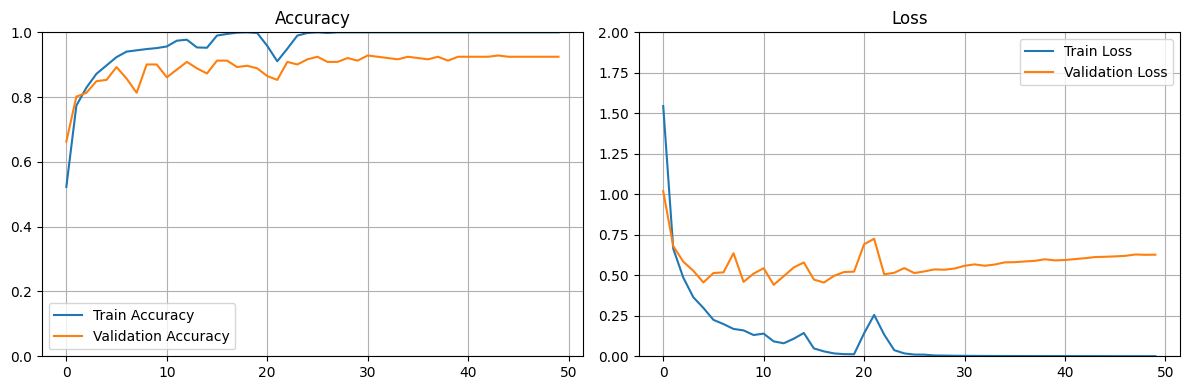

CNN1 training history saved!


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load Pre-trained Model
MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/model/audio_classification_model.h5"
model = load_model(MODEL_SAVE_PATH)
print("Pre-trained model loaded successfully.")

# Load UrbanSound8K Dataset Metadata
URBAN_CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
AUDIO_FOLDER = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"
df_urban = pd.read_csv(URBAN_CSV_PATH)

# Function to extract features
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        if np.max(np.abs(y)) < 1e-5:
            y += np.random.normal(0, 1e-5, size=y.shape)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        gtcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Placeholder for GTCC computation
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        def resize_feature(feature, target_size):
            return np.pad(feature, ((0, max(0, target_size[0] - feature.shape[0])),
                                     (0, max(0, target_size[1] - feature.shape[1]))), mode='constant')

        mfcc = resize_feature(mfcc, target_size)
        gtcc = resize_feature(gtcc, target_size)
        chroma = resize_feature(chroma, target_size)
        mel_spec = resize_feature(mel_spec, target_size)

        stacked_features = np.stack([mfcc, gtcc, chroma, mel_spec], axis=-1)
        return stacked_features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Prepare UrbanSound8K dataset
X_urban, y_urban = [], []
for _, row in tqdm(df_urban.iterrows(), total=len(df_urban)):
    file_path = os.path.join(AUDIO_FOLDER, f"fold{row['fold']}/{row['slice_file_name']}")
    label = row['classID']
    features = extract_features(file_path)
    if features is not None and features.shape == (128, 128, 4):  # Ensure correct shape
        X_urban.append(features)
        y_urban.append(label)

X_urban = np.array(X_urban, dtype=np.float32)  # Ensure homogeneous array
y_urban = np.array(y_urban, dtype=np.int64)

# Normalize features
scaler = StandardScaler()
X_urban = np.array([scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape) for x in X_urban])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_urban, y_urban, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_urban))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Modify model if class count differs
if model.output_shape[-1] != num_classes:
    model.pop()
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



# Fine-tune Model on UrbanSound8K
epochs = 50  # Fewer epochs for fine-tuning
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"UrbanSound8K Test Accuracy: {accuracy:.4f}")

# Save the retrained model
URBAN_MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/model/audio_classification_model_urban.h5"
model.save(URBAN_MODEL_SAVE_PATH)
print(f"Re-trained model saved at {URBAN_MODEL_SAVE_PATH}")


# Plot Training History
# ============================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0, 1)
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim(0, 2)
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ============================
# Save Training History as .npy
# ============================
result_dir = "/content/drive/MyDrive/Colab Notebooks/Models/Result"
np.save(os.path.join(result_dir, "cnn1_mfcc_gtcc_chroma_melspec_train_acc.npy"), history.history['accuracy'])
np.save(os.path.join(result_dir, "cnn1_mfcc_gtcc_chroma_melspec_val_acc.npy"), history.history['val_accuracy'])
np.save(os.path.join(result_dir, "cnn1_mfcc_gtcc_chroma_melspec_train_loss.npy"), history.history['loss'])
np.save(os.path.join(result_dir, "cnn1_mfcc_gtcc_chroma_melspec_val_loss.npy"), history.history['val_loss'])

print("CNN1 training history saved!")
